# Nearest-Neighbor Matching — Homework 6.1

This notebook computes ATE, ATT, ATU, and the **Optimal Treatment Effect** using 1-Nearest Neighbor matching on the confounder **Z** from `homework_6.1.csv`.

**Columns:**
- `Z`: confounder used for matching
- `X`: treatment indicator (1 = treated, 0 = untreated)
- `Y`: outcome

## Steps
1. Load data
2. Split treated vs untreated
3. Fit 1-NN on `Z` to find counterfactual matches
4. Compute ATE, ATT, ATU, and Optimal TE


In [3]:

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

pd.set_option("display.float_format", lambda x: f"{x:0.6f}")


## 1) Load dataset

In [4]:

csv_path = "homework_6.1.csv"
df = pd.read_csv(csv_path)
df.head()


,Z,X,Y
0,0.548814,0,-0.823220
1,0.715189,1,0.842405
2,0.602763,1,0.898618
3,0.544883,0,-0.817325
4,0.423655,0,-0.635482


## 2) Basic checks

In [5]:

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Z       1000 non-null   float64
 1   X       1000 non-null   int64  
 2   Y       1000 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


,Z,X,Y
count,1000.000000,1000.000000,1000.000000
mean,0.495922,0.491000,0.163240
std,0.290744,0.500169,0.754302
min,0.000546,0.000000,-1.459379
25%,0.247613,0.000000,-0.457581
50%,0.481323,0.000000,-0.017813
75%,0.737260,1.000000,0.855020
max,0.999809,1.000000,1.190403


## 3) Split groups and fit 1-NN on Z

In [6]:

treated = df[df["X"] == 1].reset_index(drop=True)
untreated = df[df["X"] == 0].reset_index(drop=True)

# Fit nearest neighbors using only confounder Z
nn_treated = NearestNeighbors(n_neighbors=1).fit(untreated[["Z"]])
nn_untreated = NearestNeighbors(n_neighbors=1).fit(treated[["Z"]])

# Index of nearest match for each item
treated_to_untreated_idx = nn_treated.kneighbors(treated[["Z"]], return_distance=False).flatten()
untreated_to_treated_idx = nn_untreated.kneighbors(untreated[["Z"]], return_distance=False).flatten()

# Counterfactual outcomes (Y) from the matched item in the other group
treated_cf = untreated.iloc[treated_to_untreated_idx]["Y"].values
untreated_cf = treated.iloc[untreated_to_treated_idx]["Y"].values


## 4) Compute effects

In [7]:

# Effects per-item
te_treated = treated["Y"].values - treated_cf            # effect for treated items
te_untreated = untreated_cf - untreated["Y"].values      # effect for untreated items

# Aggregates
ate = np.mean(np.concatenate([te_treated, te_untreated]))
att = np.mean(te_treated)
atu = np.mean(te_untreated)
optimal_te = np.max(te_untreated)  # maximum effect among untreated items

results = {
    "ATE": ate,
    "ATT": att,
    "ATU": atu,
    "Optimal TE (max over untreated)": optimal_te
}
results


{'ATE': np.float64(1.6952701427497885),
 'ATT': np.float64(1.8464085071912946),
 'ATU': np.float64(1.5494765534751722),
 'Optimal TE (max over untreated)': np.float64(2.172469885577008)}

## 5) Print results

In [8]:

for k, v in results.items():
    print(f"{k}: {v:0.6f}")


ATE: 1.695270
ATT: 1.846409
ATU: 1.549477
Optimal TE (max over untreated): 2.172470


## 6)Visualization

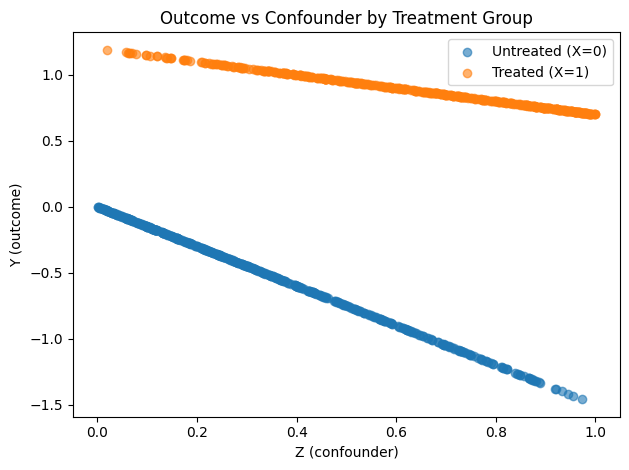

In [9]:

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df.loc[df.X==0, "Z"], df.loc[df.X==0, "Y"], label="Untreated (X=0)", alpha=0.6)
plt.scatter(df.loc[df.X==1, "Z"], df.loc[df.X==1, "Y"], label="Treated (X=1)", alpha=0.6)
plt.xlabel("Z (confounder)")
plt.ylabel("Y (outcome)")
plt.title("Outcome vs Confounder by Treatment Group")
plt.legend()
plt.tight_layout()
plt.show()


## 7) Alternative Estimation of Marginal Treatment Effect

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Load data
df = pd.read_csv("homework_6.1.csv")
treated = df[df["X"] == 1].reset_index(drop=True)
untreated = df[df["X"] == 0].reset_index(drop=True)

# 1-NN matching on Z (untreated -> treated) to get counterfactual for untreated items
nn_untreated = NearestNeighbors(n_neighbors=1).fit(treated[["Z"]])
untreated_to_treated_idx = nn_untreated.kneighbors(untreated[["Z"]], return_distance=False).flatten()

# Per-item treatment effect for untreated units (what they'd gain if treated)
untreated_cf = treated.iloc[untreated_to_treated_idx]["Y"].values
te_untreated = untreated_cf - untreated["Y"].values  # effects distribution for untreated

# Proposed proxy for MTE: 90th percentile of the untreated effects
mte_p90 = float(np.percentile(te_untreated, 90))

# Bootstrap a 95% CI for the 90th percentile to show uncertainty
rng = np.random.default_rng(42)
B = 1000
boot_p90 = np.empty(B)
n = len(te_untreated)
for b in range(B):
    sample = te_untreated[rng.integers(0, n, size=n)]
    boot_p90[b] = np.percentile(sample, 90)

ci_lower = float(np.percentile(boot_p90, 2.5))
ci_upper = float(np.percentile(boot_p90, 97.5))

print(f"MTE proxy (90th percentile): {mte_p90:.3f}")
print(f"95% CI via bootstrap: [{ci_lower:.3f}, {ci_upper:.3f}]")


MTE proxy (90th percentile): 1.928
95% CI via bootstrap: [1.894, 1.970]


Using the 90th percentile of the untreated effects gives a more stable estimate of the Marginal Treatment Effect (≈1.93).